<a href="https://colab.research.google.com/github/StoneMaenggu/coda-modeling/blob/main/Gloss2Text/KoBART/0824_KoBART_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KoBART Basline Train
- 모듈에서 불러오는 모델 아니고 huggingface에서 불러와서 적용
- 일반적 tokenizer말고 BART에 최적화된 토크나이저 불러옴

https://huggingface.co/hyunwoongko/kobart

## 0. 라이브러리 및 데이터 불러오기

In [2]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import torch.optim as optim

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device('cpu')

In [4]:
from transformers import PreTrainedTokenizerFast, BartForConditionalGeneration

tokenizer = PreTrainedTokenizerFast.from_pretrained('hyunwoongko/kobart')
model = BartForConditionalGeneration.from_pretrained("hyunwoongko/kobart").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/337 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/109 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


pytorch_model.bin:   0%|          | 0.00/496M [00:00<?, ?B/s]

데이터 불러오기

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/AIRC-KETI/GKSL-dataset/main/dataset/GKSL3k_original.csv')
df.columns = ['dataset', 'video_num', 'morph', 'question', 'gloss', 'text']
df.head(30)

,dataset,video_num,morph,question,gloss,text
0,KETI-Emergency,NaN,NaN,False,집 불,집에 불이 났어요.
1,KETI-Emergency,NaN,NaN,False,집 도둑 넘어오다,집에 도둑이 들어왔어요.
2,KETI-Emergency,NaN,NaN,False,누가 교통사고,어떤 사람이 교통사고를 당했어요.
3,KETI-Emergency,NaN,NaN,False,먹다 중간 목 실수 삼키다,식사를 하다가 목에 음식이 걸렸어요.
4,KETI-Emergency,NaN,NaN,False,홍수 집 물 채우다,홍수가 나서 집이 물에 잠기고 있어요.
5,KETI-Emergency,NaN,NaN,False,엘리베이터 갑자기 멈추다,엘리베이터가 갑자기 중간에 멈췄어요.
6,KETI-Emergency,NaN,NaN,False,누가 자살 중,어떤 사람이 자살을 시도하고 있어요.
7,KETI-Emergency,NaN,NaN,False,누가 바다 빠지다 헤엄치다,어떤 사람이 바다에 빠졌어요.
8,KETI-Emergency,NaN,NaN,False,바다 가깝다 곳 상어 오다,해안가에 상어가 나타났어요.
9,KETI-Emergency,NaN,NaN,False,바다 가깝다 곳 해파리 오다,해안가에 해파리가 나타났어요.


## 1. 데이터 파악

In [6]:
len(df), len(df.gloss.unique()), len(df.text.unique())

(3052, 2115, 1378)

왜 똑같은 문장이 많지?

- 문맥에 따라 gloss가 다르게 text로 변환되는 경우가 있어서 똑같은 gloss는 많은 걸로 보임
- text는..?
- 추가로 의문문 유무 파악은 표정에서 따내는 건가

In [9]:
print(len(df[df.question==True]))
df[df.question==True].head(10)

1346


,dataset,video_num,morph,question,gloss,text
106,NIA-2020,2.0,X,True,왼쪽,왼쪽이요?
108,NIA-2020,4.0,X,True,오른쪽,오른쪽이요?
110,NIA-2020,6.0,X,True,여기,이것인가요?
112,NIA-2020,8.0,NaN,True,저기,저것인가요?
114,NIA-2020,10.0,NaN,True,운전 천천히,천천히 가드릴까요?
116,NIA-2020,12.0,NaN,True,가다 빨리,빨리 가드릴까요?
118,NIA-2020,14.0,NaN,True,시간 급하다,많이 급하세요?
120,NIA-2020,16.0,X,True,급하다,급하세요?
122,NIA-2020,18.0,NaN,True,약속 늦다,약속시간에 늦으셨나요?
124,NIA-2020,20.0,X,True,나,저요?


우리는 기록용이니까 일단 의문문은 포함하지 않고 진행


=> 근데 이러면 데이터 절반이 날라감

### 데이터 전처리

In [10]:
df = df[df.question==False]
df = df[['gloss', 'text']]
df

,gloss,text
0,집 불,집에 불이 났어요.
1,집 도둑 넘어오다,집에 도둑이 들어왔어요.
2,누가 교통사고,어떤 사람이 교통사고를 당했어요.
3,먹다 중간 목 실수 삼키다,식사를 하다가 목에 음식이 걸렸어요.
4,홍수 집 물 채우다,홍수가 나서 집이 물에 잠기고 있어요.
...,...,...
3047,도착 시간 저녁 9시 정도,도착시간은 오후 9시가 되겠습니다
3048,아이 지금 5 되다,아이가 다섯 살이 되었다
3049,잘 되다 부탁,잘 되길 바래
3050,미래 의사 원하다,커서 의사가 되고 싶다


In [11]:
df.head(10)

,gloss,text
0,집 불,집에 불이 났어요.
1,집 도둑 넘어오다,집에 도둑이 들어왔어요.
2,누가 교통사고,어떤 사람이 교통사고를 당했어요.
3,먹다 중간 목 실수 삼키다,식사를 하다가 목에 음식이 걸렸어요.
4,홍수 집 물 채우다,홍수가 나서 집이 물에 잠기고 있어요.
5,엘리베이터 갑자기 멈추다,엘리베이터가 갑자기 중간에 멈췄어요.
6,누가 자살 중,어떤 사람이 자살을 시도하고 있어요.
7,누가 바다 빠지다 헤엄치다,어떤 사람이 바다에 빠졌어요.
8,바다 가깝다 곳 상어 오다,해안가에 상어가 나타났어요.
9,바다 가깝다 곳 해파리 오다,해안가에 해파리가 나타났어요.


In [12]:
# 토큰화할 문장
sentence = "해안가에 해파리가 나타났어요."

# 문장을 토큰화
encoded_input = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True)
tokens = tokenizer.tokenize(sentence)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

# 결과 출력
print("Original Sentence: ", sentence)
print("Tokens: ", tokens)
print("Token IDs: ", token_ids)
print("Decoded Sentence: ", tokenizer.decode(encoded_input['input_ids'][0], skip_special_tokens=True))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Original Sentence:  해안가에 해파리가 나타났어요.
Tokens:  ['▁해안', '가에', '▁해', '파', '리가', '▁나타났', '어요.']
Token IDs:  [23159, 17458, 14088, 13369, 14493, 19743, 17687]
Decoded Sentence:  해안가에 해파리가 나타났어요.


### 문장 길이 시각화
max_len 설정을 위함

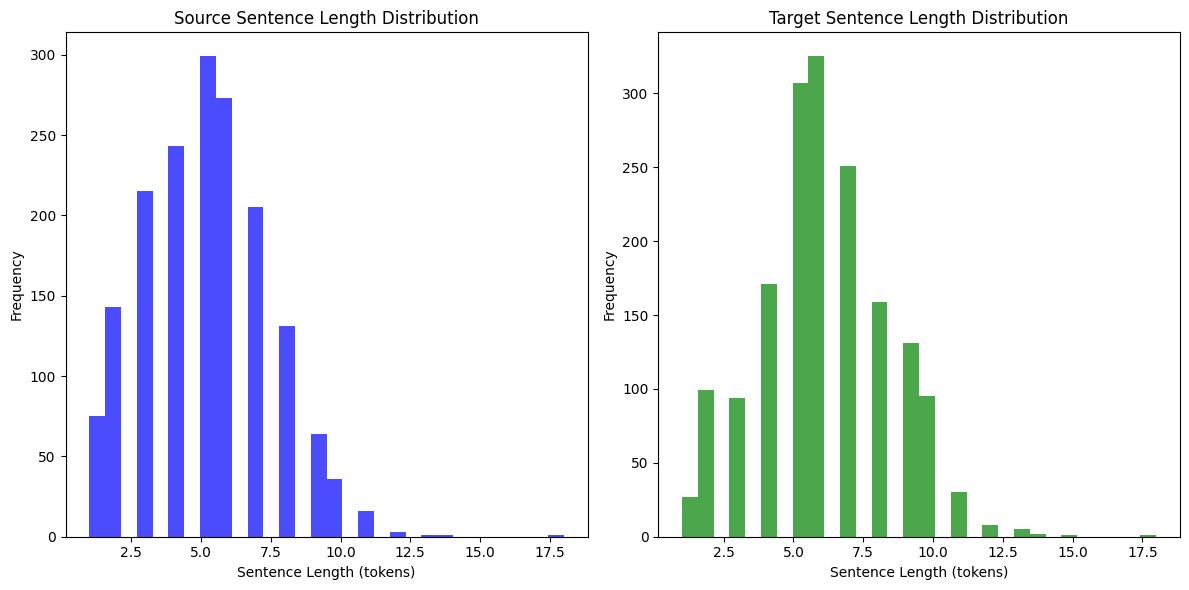

In [13]:
import matplotlib.pyplot as plt

# 각 문장의 토큰 길이를 KoBART 토크나이저로 계산 -> 서브워드 단어로 더 잘게 쪼개줌
df['source_len'] = df['gloss'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))
df['target_len'] = df['text'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))

# 히스토그램을 그려서 분포 확인
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df['source_len'], bins=30, color='blue', alpha=0.7)
plt.title('Source Sentence Length Distribution')
plt.xlabel('Sentence Length (tokens)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['target_len'], bins=30, color='green', alpha=0.7)
plt.title('Target Sentence Length Distribution')
plt.xlabel('Sentence Length (tokens)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [14]:
# 문장 길이 통계
source_stats = df['source_len'].describe(percentiles=[.25, .5, .75, .9, .95, .99])
target_stats = df['target_len'].describe(percentiles=[.25, .5, .75, .9, .95, .99])

print("Source Sentence Length Stats:\n", source_stats)
print("\nTarget Sentence Length Stats:\n", target_stats)

Source Sentence Length Stats:
 count    1706.000000
mean        5.150645
std         2.269818
min         1.000000
25%         3.000000
50%         5.000000
75%         7.000000
90%         8.000000
95%         9.000000
99%        11.000000
max        18.000000
Name: source_len, dtype: float64

Target Sentence Length Stats:
 count    1706.000000
mean        6.087925
std         2.336101
min         1.000000
25%         5.000000
50%         6.000000
75%         8.000000
90%         9.000000
95%        10.000000
99%        11.000000
max        18.000000
Name: target_len, dtype: float64


데이터셋의 문장 자체가 짧아서 짧게 지정하는데
- 메모리 효율성측면에서 max len이 너무 크면 메모리 낭비가 발생할 수 있어 작게 설정하는 것이 유리함



근데 평균적으로 이렇게 짧은 문장을 학습하지 않는걸까?
- 128 ~ 512 토큰: 일반적인 max_len 값으로, 대부분의 문장을 커버
- 1024 토큰: 더 긴 문장을 처리할 때 사용됩니다. GPT-2/3 같은 모델에서 긴 컨텍스트를 처리하기 위해 이 정도의 길이를 설정
- 2048 ~ 4096 토큰: 최근 큰 언어 모델(LLM)에서 더욱 긴 문맥을 처리하기 위해 사용되며, OpenAI의 GPT-4, Google's PaLM 등에서 이 정도 길이가 적용

## 2. 데이터 로더 생성

In [15]:
class GlossDataset(Dataset):
    def __init__(self, glosses, texts, tokenizer, max_len=10):
        self.glosses = glosses
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    # 데이터셋의 크기를 반환
    def __len__(self):
        return len(self.glosses)

    def __getitem__(self, idx):
        # 데이터 로드 및 전처리
        gloss = str(self.glosses[idx])
        text = str(self.texts[idx])

        # 토큰화
        inputs = self.tokenizer(
            gloss,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt" # 토큰화된 결과를 PyTorch 텐서로 반환
        )

        outputs = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        # 텐서 데이터 처리
        input_ids = inputs.input_ids.squeeze() # 1차원 처리해 gloss 토큰 id 텐서
        attention_mask = inputs.attention_mask.squeeze() # 마스킹 처리
        labels = outputs.input_ids.squeeze() # 1차원 처리해 text 토큰 id 텐서
        labels[labels == tokenizer.pad_token_id] = -100  # labels 텐서에서 패딩 토큰의 ID를 -100 변경 -> 학습 시 영향 안줌

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        } # 모델 학습에 사용될 데이터 로더에 의해 처리

In [16]:
from sklearn.model_selection import train_test_split

# 데이터셋 분할
train_glosses, val_glosses, train_texts, val_texts = train_test_split(df['gloss'].tolist(), df['text'].tolist(), test_size=0.2, random_state=42)
val_glosses, test_glosses, val_texts, test_texts = train_test_split(val_glosses, val_texts, test_size=0.5, random_state=42)

# 데이터셋 생성
train_dataset = GlossDataset(glosses=train_glosses, texts=train_texts, tokenizer=tokenizer)
val_dataset = GlossDataset(glosses=val_glosses, texts=val_texts, tokenizer=tokenizer)
test_dataset = GlossDataset(glosses=test_glosses, texts=test_texts, tokenizer=tokenizer)

# 데이터로더 생성
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
train_dataset[0]

{'input_ids': tensor([    0, 14245,  9618, 11696, 12037, 16212, 28379,     1,     3,     3]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0]),
 'labels': tensor([    0, 14245,  9618, 11696, 12037, 16212, 10338, 14039, 12258,     1])}

## 3. 모델 준비

In [18]:
import torch
from transformers import AdamW, get_linear_schedule_with_warmup

# 옵티마이저와 손실 함수 설정
optimizer = AdamW(model.parameters(), lr=2e-5)  # 학습률은 실험적으로 조정할 수 있음 1e-4, 1e-5
loss_fn = torch.nn.CrossEntropyLoss()

# 학습률 스케줄러 설정
num_epochs = 100

total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## 4. KoBART 학습


In [19]:
# 체크포인트를 저장할 디렉토리 설정
import os

checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [20]:
model

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(30000, 768, padding_idx=3)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(30000, 768, padding_idx=3)
      (embed_positions): BartLearnedPositionalEmbedding(1028, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): Laye

In [21]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 4.6 MB/s eta 0:00:00


In [22]:
# meteor_score
import nltk

nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [23]:
import numpy as np
import sacrebleu
from nltk.translate.meteor_score import meteor_score
from tqdm import tqdm
import torch

# 손실 값과 성능 지표를 저장할 리스트 초기화
train_losses = []
val_losses = []
bleu_scores = []
meteor_scores = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU 사용 설정
model.to(device)  # 모델을 GPU로 이동

for epoch in range(num_epochs):
    model.train()  # 학습 모드로 전환
    total_loss = 0

    print(f'\nStarting epoch {epoch+1}/{num_epochs}')

    # tqdm을 사용하여 배치 진행 상태 표시
    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
        optimizer.zero_grad()  # 기울기 초기화

        # 입력 데이터를 GPU로 이동
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # 모델에 데이터 전달
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()  # 역전파
        optimizer.step()  # 옵티마이저 스텝
        scheduler.step()  # 학습률 스케줄러 스텝

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)  # 훈련 손실 저장

    # Epoch 종료 후 검증 데이터셋에서 성능 평가
    model.eval()  # 평가 모드로 전환
    total_val_loss = 0
    predictions = []
    references = []

    with torch.no_grad():
        # tqdm을 사용하여 검증 배치 진행 상태 표시
        for batch in tqdm(val_dataloader, desc='Validation', unit='batch'):
            # 입력 데이터를 GPU로 이동
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

            # 예측 결과 디코딩
            decoded_preds = tokenizer.batch_decode(outputs.logits.argmax(dim=-1).tolist(), skip_special_tokens=True)

            # 실제 레이블 디코딩
            decoded_labels = []
            for label in labels:
                label_ids = label[label != tokenizer.pad_token_id].tolist()
                # 유효한 토큰 ID 범위 내에서만 필터링
                valid_label_ids = [token_id for token_id in label_ids if 0 <= token_id < tokenizer.vocab_size]
                decoded_label = tokenizer.decode(valid_label_ids, skip_special_tokens=True)
                decoded_labels.append(decoded_label)

            # 예측 결과와 참조 번역 수집
            predictions.extend(decoded_preds)
            references.extend(decoded_labels)

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)  # 검증 손실 저장

    # BLEU 점수 계산
    bleu_score_value = sacrebleu.corpus_bleu(predictions, [references])
    bleu_scores.append(bleu_score_value.score)

    # METEOR 점수 계산 (참조 및 예측을 토큰화하여 전달)
    meteor_score_value = np.mean([meteor_score([ref.split()], pred.split()) for ref, pred in zip(references, predictions)])
    meteor_scores.append(meteor_score_value)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, BLEU: {bleu_score_value.score:.4f}, METEOR: {meteor_score_value:.4f}')

    # 체크포인트 저장
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch32_{epoch+1}.pt')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': avg_loss,
        'val_loss': avg_val_loss,
        'bleu_score': bleu_score_value.score,
        'meteor_score': meteor_score_value
    }, checkpoint_path)

    print(f'Checkpoint saved to {checkpoint_path}')



Starting epoch 1/100


Validation: 100%|██████████| 6/6 [00:02<00:00,  2.15batch/s]


Epoch 1/100, Loss: 3.4298, Validation Loss: 1.7362, BLEU: 6.9427, METEOR: 0.1915
Checkpoint saved to ./checkpoints/checkpoint_epoch32_1.pt

Starting epoch 2/100


Validation: 100%|██████████| 6/6 [00:00<00:00, 25.42batch/s]


Epoch 2/100, Loss: 1.7469, Validation Loss: 1.3435, BLEU: 14.2867, METEOR: 0.3393
Checkpoint saved to ./checkpoints/checkpoint_epoch32_2.pt

Starting epoch 3/100


Validation: 100%|██████████| 6/6 [00:00<00:00, 25.60batch/s]


Epoch 3/100, Loss: 1.3769, Validation Loss: 1.1441, BLEU: 15.0336, METEOR: 0.3946
Checkpoint saved to ./checkpoints/checkpoint_epoch32_3.pt

Starting epoch 4/100


Validation: 100%|██████████| 6/6 [00:00<00:00, 27.32batch/s]


Epoch 4/100, Loss: 1.1144, Validation Loss: 1.0169, BLEU: 19.8648, METEOR: 0.4312
Checkpoint saved to ./checkpoints/checkpoint_epoch32_4.pt

Starting epoch 5/100


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.85batch/s]


Epoch 5/100, Loss: 0.9434, Validation Loss: 0.9473, BLEU: 23.3632, METEOR: 0.4786
Checkpoint saved to ./checkpoints/checkpoint_epoch32_5.pt

Starting epoch 6/100


Validation: 100%|██████████| 6/6 [00:00<00:00, 27.17batch/s]


Epoch 6/100, Loss: 0.7689, Validation Loss: 0.9086, BLEU: 25.1805, METEOR: 0.5020
Checkpoint saved to ./checkpoints/checkpoint_epoch32_6.pt

Starting epoch 7/100


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.81batch/s]


Epoch 7/100, Loss: 0.6524, Validation Loss: 0.8893, BLEU: 25.4215, METEOR: 0.5122
Checkpoint saved to ./checkpoints/checkpoint_epoch32_7.pt

Starting epoch 8/100


Validation: 100%|██████████| 6/6 [00:00<00:00, 27.01batch/s]


Epoch 8/100, Loss: 0.5600, Validation Loss: 0.8970, BLEU: 27.7650, METEOR: 0.5194
Checkpoint saved to ./checkpoints/checkpoint_epoch32_8.pt

Starting epoch 9/100


Validation: 100%|██████████| 6/6 [00:00<00:00, 27.53batch/s]


Epoch 9/100, Loss: 0.4817, Validation Loss: 0.8858, BLEU: 28.3275, METEOR: 0.5197
Checkpoint saved to ./checkpoints/checkpoint_epoch32_9.pt

Starting epoch 10/100


Validation: 100%|██████████| 6/6 [00:00<00:00, 27.95batch/s]


Epoch 10/100, Loss: 0.4082, Validation Loss: 0.9008, BLEU: 29.2187, METEOR: 0.5339
Checkpoint saved to ./checkpoints/checkpoint_epoch32_10.pt

Starting epoch 11/100


Validation: 100%|██████████| 6/6 [00:00<00:00, 27.37batch/s]


Epoch 11/100, Loss: 0.3536, Validation Loss: 0.8974, BLEU: 29.0527, METEOR: 0.5291
Checkpoint saved to ./checkpoints/checkpoint_epoch32_11.pt

Starting epoch 12/100


Validation: 100%|██████████| 6/6 [00:00<00:00, 27.79batch/s]


Epoch 12/100, Loss: 0.2977, Validation Loss: 0.8988, BLEU: 29.5047, METEOR: 0.5316
Checkpoint saved to ./checkpoints/checkpoint_epoch32_12.pt

Starting epoch 13/100


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.16batch/s]


Epoch 13/100, Loss: 0.2558, Validation Loss: 0.9061, BLEU: 29.6728, METEOR: 0.5319
Checkpoint saved to ./checkpoints/checkpoint_epoch32_13.pt

Starting epoch 14/100


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.36batch/s]


Epoch 14/100, Loss: 0.2244, Validation Loss: 0.9153, BLEU: 29.1961, METEOR: 0.5399
Checkpoint saved to ./checkpoints/checkpoint_epoch32_14.pt

Starting epoch 15/100


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.21batch/s]


Epoch 15/100, Loss: 0.1970, Validation Loss: 0.9347, BLEU: 28.1272, METEOR: 0.5249
Checkpoint saved to ./checkpoints/checkpoint_epoch32_15.pt

Starting epoch 16/100


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.89batch/s]


Epoch 16/100, Loss: 0.1681, Validation Loss: 0.9326, BLEU: 27.8593, METEOR: 0.5421
Checkpoint saved to ./checkpoints/checkpoint_epoch32_16.pt

Starting epoch 17/100


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.10batch/s]


Epoch 17/100, Loss: 0.1416, Validation Loss: 0.9404, BLEU: 28.9695, METEOR: 0.5312
Checkpoint saved to ./checkpoints/checkpoint_epoch32_17.pt

Starting epoch 18/100


Validation: 100%|██████████| 6/6 [00:00<00:00, 27.47batch/s]


Epoch 18/100, Loss: 0.1258, Validation Loss: 0.9490, BLEU: 28.1233, METEOR: 0.5295
Checkpoint saved to ./checkpoints/checkpoint_epoch32_18.pt

Starting epoch 19/100


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.24batch/s]


Epoch 19/100, Loss: 0.1159, Validation Loss: 0.9521, BLEU: 27.7121, METEOR: 0.5322
Checkpoint saved to ./checkpoints/checkpoint_epoch32_19.pt

Starting epoch 20/100


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.74batch/s]


Epoch 20/100, Loss: 0.1001, Validation Loss: 0.9554, BLEU: 27.9590, METEOR: 0.5354
Checkpoint saved to ./checkpoints/checkpoint_epoch32_20.pt

Starting epoch 21/100


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.96batch/s]


Epoch 21/100, Loss: 0.0936, Validation Loss: 0.9577, BLEU: 28.1940, METEOR: 0.5359
Checkpoint saved to ./checkpoints/checkpoint_epoch32_21.pt

Starting epoch 22/100


Validation: 100%|██████████| 6/6 [00:00<00:00, 25.84batch/s]


Epoch 22/100, Loss: 0.0750, Validation Loss: 0.9626, BLEU: 28.6446, METEOR: 0.5448
Checkpoint saved to ./checkpoints/checkpoint_epoch32_22.pt

Starting epoch 23/100


Epoch 23/100:  30%|███       | 13/43 [00:01<00:04,  7.20batch/s]


KeyboardInterrupt: 

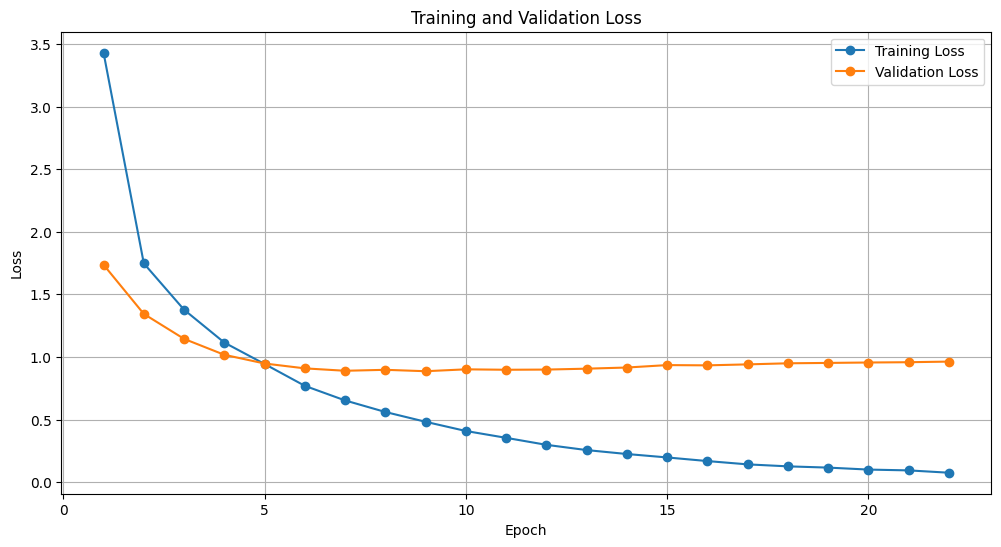

In [24]:
# 손실 값 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

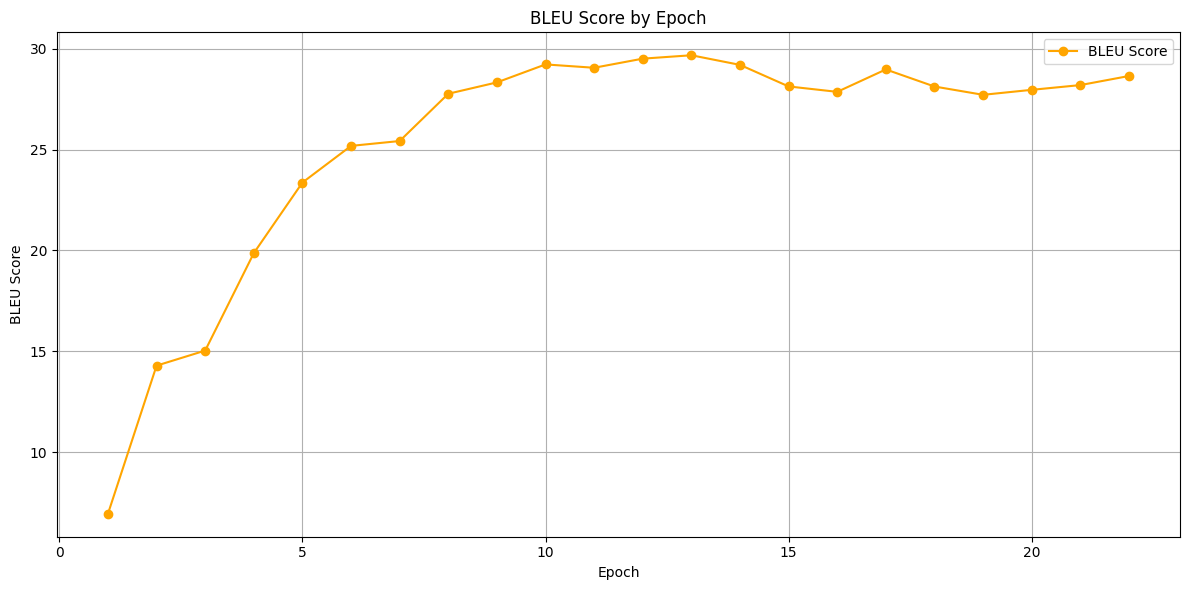

In [25]:
# BLEU 점수 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(bleu_scores) + 1), bleu_scores, label='BLEU Score', marker='o', color='orange')
plt.xlabel('Epoch')
plt.ylabel('BLEU Score')
plt.title('BLEU Score by Epoch')
plt.legend()
plt.grid(True)

# 전체 시각화 출력
plt.tight_layout()
plt.show()

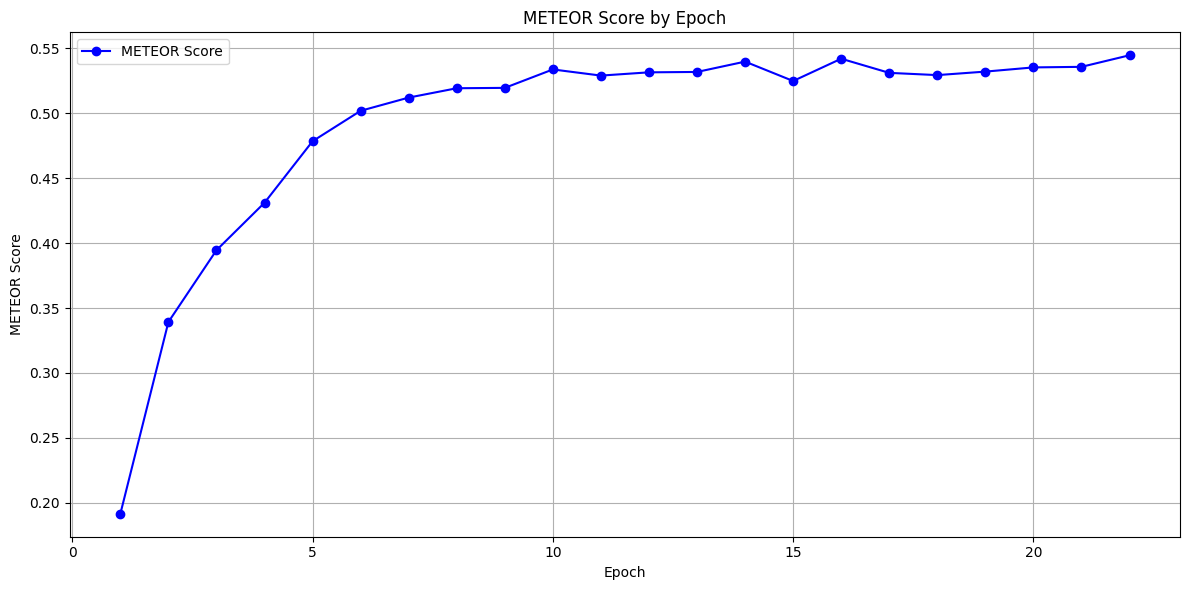

In [26]:
# Meteor 점수 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(meteor_scores) + 1), meteor_scores, label='METEOR Score', marker='o', color='BLUE')
plt.xlabel('Epoch')
plt.ylabel('METEOR Score')
plt.title('METEOR Score by Epoch')
plt.legend()
plt.grid(True)

# 전체 시각화 출력
plt.tight_layout()
plt.show()

## 5. test

In [27]:
(np.argmin(val_losses)+1, np.argmax(bleu_scores)+1, np.argmax(meteor_scores)+1)

(9, 13, 22)

In [37]:
# 체크포인트 로드
checkpoint_path = './checkpoints/checkpoint_epoch32_21.pt'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

In [29]:
model

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(30000, 768, padding_idx=3)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(30000, 768, padding_idx=3)
      (embed_positions): BartLearnedPositionalEmbedding(1028, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): Laye

In [30]:
!pip install sacrebleu

In [38]:
import torch
import sacrebleu
import numpy as np
from nltk.translate.meteor_score import meteor_score
from tqdm import tqdm

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # 모델을 GPU로 이동

# 모델을 평가 모드로 설정
model.eval()

# 예측 및 참조 번역 수집
predictions = []
references = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        # 입력 데이터를 GPU로 이동
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # 모델에 데이터 전달
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=256,  # 적절한 max_length 설정
            length_penalty=2.0,  # 번역 길이 조절
            num_beams=4,  # 빔 서치의 수
            early_stopping=True
        )

        # 예측 결과 디코딩
        decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        # 실제 레이블 디코딩
        decoded_labels = []
        for label in batch['labels']:
            label_ids = label[label != tokenizer.pad_token_id].tolist()
            if label_ids:
                try:
                    decoded_label = tokenizer.decode(label_ids, skip_special_tokens=True)
                except OverflowError:
                    decoded_label = "[UNK]"  # OverflowError 발생 시 대체 토큰
                decoded_labels.append(decoded_label)
            else:
                decoded_labels.append('')  # 빈 문자열로 처리

        # 예측 결과와 참조 번역 수집
        predictions.extend(decoded_preds)
        references.extend(decoded_labels)

# BLEU 점수 계산
bleu_score = sacrebleu.corpus_bleu(predictions, [references])
print(f'BLEU score: {bleu_score.score:.4f}')

# METEOR 점수 계산
meteor_score_value = np.mean([meteor_score([ref.split()], pred.split()) for ref, pred in zip(references, predictions)])
print(f'METEOR score: {meteor_score_value:.4f}')

Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.98it/s]

BLEU score: 10.2986
METEOR score: 0.1527


In [ ]:
import torch

def generate_translation(model, tokenizer, sentences, max_length=50):
    model.eval()
    translations = []
    for sentence in sentences:
        # 토큰화 및 텐서 변환
        inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding='max_length', max_length=max_length)

        # GPU가 사용 중이면 데이터를 GPU로 이동
        input_ids = inputs['input_ids'].to(model.device)
        attention_mask = inputs['attention_mask'].to(model.device)

        # 모델에 데이터 전달
        output_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            num_beams=5,  # Beam search 설정
            early_stopping=True
        )

        # 디코딩
        for output in output_ids:
            translation = tokenizer.decode(output, skip_special_tokens=True)
            translations.append(translation)

    return translations

# 테스트 문장
test_sentences = ["여름 덥다 화 난다", "목 마르다 물 부탁"]
translations = generate_translation(model, tokenizer, test_sentences)
print(translations)

['여름 더워서 화났어', '목 분실하였습니다.']
